In [2]:
import geopandas as gpd 

In [3]:
nyc_claustrophobia = gpd.read_parquet("../data/nyc/claustrophobia/nyc_sidewalks_claustrophobia.parquet")

In [4]:
nyc_claustrophobia.isna().sum()

point_index                   0
geometry                      0
claustrophobia_95th      311180
claustrophobia_median    311180
NAMELSAD20                 4308
tsw                        4308
pedestrians_median       310758
pedestrians_95th         310758
available_space               0
total_space                   0
space_taken                   0
dtype: int64

In [5]:
nyc_claustrophobia['claustrophobia_median'].describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).apply(lambda x: f"{x:.3f}" if x > 0 else "0.000")

count    1017120.000
mean           0.076
std            0.251
min            0.006
1%             0.010
5%             0.013
10%            0.015
25%            0.018
50%            0.023
75%            0.029
90%            0.039
95%            0.488
99%            1.280
max            3.077
Name: claustrophobia_median, dtype: object

In [6]:
nyc_claustrophobia['claustrophobia_95th'].describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).apply(lambda x: f"{x:.3f}" if x > 0 else "0.000")

count    1017120.000
mean           1.032
std            1.265
min            0.008
1%             0.013
5%             0.018
10%            0.022
25%            0.028
50%            0.759
75%            1.500
90%            2.586
95%            3.450
99%            5.689
max           10.111
Name: claustrophobia_95th, dtype: object

In [7]:
ntas_nyc = gpd.read_file('../data/nyc/geo/nta-nyc-2020.geojson')

In [8]:
ntas_nyc['ntaname'].values

array(['Greenpoint', 'Williamsburg', 'South Williamsburg',
       'East Williamsburg', 'Brooklyn Heights',
       'Downtown Brooklyn-DUMBO-Boerum Hill', 'Fort Greene',
       'Clinton Hill', 'Brooklyn Navy Yard', 'Bedford-Stuyvesant (West)',
       'Bedford-Stuyvesant (East)', 'Bushwick (West)', 'Bushwick (East)',
       'The Evergreens Cemetery', 'Cypress Hills',
       'East New York (North)', 'East New York-New Lots',
       'Spring Creek-Starrett City', 'East New York-City Line',
       'Highland Park-Cypress Hills Cemeteries (South)',
       'Carroll Gardens-Cobble Hill-Gowanus-Red Hook', 'Park Slope',
       'Windsor Terrace-South Slope', 'Sunset Park (West)',
       'Sunset Park (Central)', 'Green-Wood Cemetery', 'Prospect Heights',
       'Crown Heights (North)', 'Lincoln Terrace Park',
       'Crown Heights (South)', 'Prospect Lefferts Gardens-Wingate',
       'Bay Ridge', 'Dyker Heights', 'Fort Hamilton', 'Dyker Beach Park',
       'Bensonhurst', 'Bath Beach', 'Gravesend (Wes

In [9]:
times_square = ntas_nyc[ntas_nyc['ntaname'] == 'Midtown-Times Square'].to_crs('EPSG:2263')
times_square

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry
130,24552509.6358,Midtown-Times Square,MN05 Midtown-Flatiron-Union Square (CD 5 Appro...,21258.4010015,Manhattan,0,MN0502,1,061,Mdtwn_TmSq,MN05,"MULTIPOLYGON (((991725.177 217725.51, 992169.4..."


In [10]:
# crop claustrophobia to times square
times_square_claustrophobia = nyc_claustrophobia.clip(times_square.geometry.values[0])

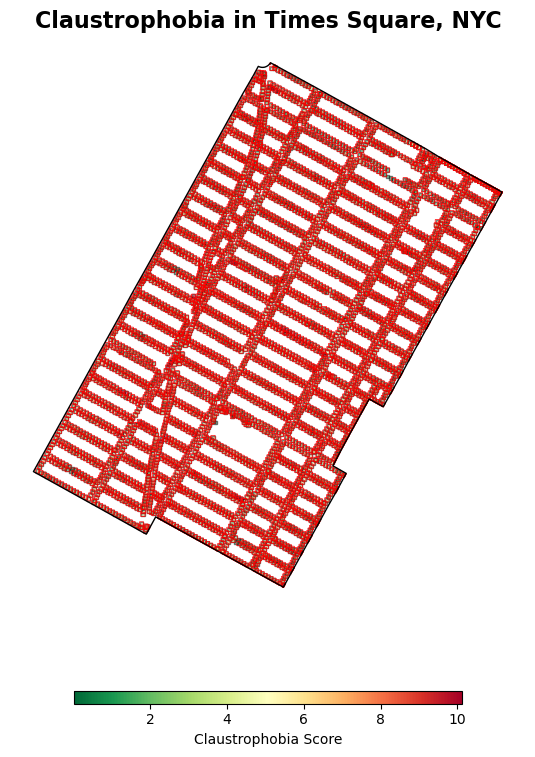

In [11]:
# plot 
import matplotlib.pyplot as plt

COL_TO_USE='claustrophobia_95th'

cmap = plt.get_cmap('RdYlGn').reversed()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times_square.boundary.plot(ax=ax, color='black', linewidth=1)
times_square_claustrophobia.plot(column=COL_TO_USE, ax=ax, legend=True, cmap=cmap, edgecolor='black', alpha=0.5,
                                 legend_kwds={'label': "Claustrophobia Score", 'orientation': "horizontal", 'pad': 0.1, 'shrink': 0.5, 'aspect': 30})

# plot outlines of points where claustrophobia is >= 1
times_square_claustrophobia[times_square_claustrophobia[COL_TO_USE] >= 1].buffer(5).plot(ax=ax, color='none', edgecolor='red', linewidth=0.5)

ax.set_axis_off()

ax.set_title('Claustrophobia in Times Square, NYC', fontsize=16, fontweight='bold')

plt.savefig('_debug_figs/claustrophobia_times_square.png', dpi=300, bbox_inches='tight')



In [12]:
# write a helper function that plots claustrophobia for all ntas in ntas_nyc 
def plot_claustrophobia(nta_name, ntas_nyc, nyc_claustrophobia, col_to_use='claustrophobia_95th'):
    nta = ntas_nyc[ntas_nyc['ntaname'] == nta_name].to_crs('EPSG:2263')
    nta_claustrophobia = nyc_claustrophobia.clip(nta.geometry.values[0])

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    nta.boundary.plot(ax=ax, color='black', linewidth=1)
    nta_claustrophobia.plot(column=col_to_use, ax=ax, legend=True, cmap=cmap, edgecolor='black', alpha=0.5,
                            legend_kwds={'label': "Claustrophobia Score", 'orientation': "horizontal", 'pad': 0.1, 'shrink': 0.5, 'aspect': 30})

    # plot outlines of points where claustrophobia is >= 1
    nta_claustrophobia[nta_claustrophobia[col_to_use] >= 1].buffer(5).plot(ax=ax, color='none', edgecolor='red', linewidth=0.5)

    ax.set_axis_off()

    ax.set_title(f'Claustrophobia in {nta_name}, NYC', fontsize=16, fontweight='bold')

    plt.savefig(f'_debug_figs/{col_to_use}_{nta_name}.png', dpi=300, bbox_inches='tight')

    plt.close()

In [13]:
# run 
for nta_name in ntas_nyc['ntaname'].values:
    plot_claustrophobia(nta_name, ntas_nyc, nyc_claustrophobia, col_to_use='claustrophobia_95th')
    # run for median 
    plot_claustrophobia(nta_name, ntas_nyc, nyc_claustrophobia, col_to_use='claustrophobia_median')

/tmp/ipykernel_1339805/827000192.py:12: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  nta_claustrophobia[nta_claustrophobia[col_to_use] >= 1].buffer(5).plot(ax=ax, color='none', edgecolor='red', linewidth=0.5)
/tmp/ipykernel_1339805/827000192.py:12: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  nta_claustrophobia[nta_claustrophobia[col_to_use] >= 1].buffer(5).plot(ax=ax, color='none', edgecolor='red', linewidth=0.5)
/tmp/ipykernel_1339805/827000192.py:12: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  nta_claustrophobia[nta_claustrophobia[col_to_use] >= 1].buffer(5).plot(ax=ax, color='none', edgecolor='red', linewidth=0.5)
/tmp/ipykernel_1339805/827000192.py:12: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  nta_claustrophobia[nta_claustrophobia[col_to_use] >= 1].buffer(5).plot(ax=ax, color='none', 